## Prediction with Logistic Regression

We apply the same procedures with Logistic Regression.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split,KFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,\
recall_score,roc_curve,auc

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from function import split_train_test,make_data_balance

In [2]:
np.random.seed(1)

Import data containing features and target.

In [3]:
Xy = np.loadtxt('data_processed.dat') 
X = Xy[:,:-1]
y = Xy[:,-1]

In [4]:
X,y = make_data_balance(X,y)

Shuffle the data.

In [5]:
X, y = shuffle(X, y, random_state=1)

We split data into training and test sets, then we use the training to train our model, use the test set to evaluate the performance of our method. The size of test set can be changed by `test_size`.

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state = 1)

We rescale the data.

In [7]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

We now train model with the `X_train` and `y_train`. Please note that our model has one hyper parameter `l2`. We will use cross validation to find the optimal value of `l2`. This process will also split the training set again into `X_train1` and `X_val`. The test set is assumed to be unknown.

In [8]:
n = X_train.shape[1]

l2 = [0.01,0.1,1.,10.,100.]
nl2 = len(l2)

# cross validation 
kf = 4   
kfold = KFold(n_splits=kf,shuffle=False,random_state=1)

h01 = np.zeros(kf)
w1 = np.zeros((kf,n))
cost1 = np.zeros(kf)

h0 = np.zeros(nl2)
w = np.zeros((nl2,n))
cost = np.zeros(nl2)            
for il2 in range(len(l2)):            
    model = LogisticRegression(penalty='l2',C=1./l2[il2],solver='liblinear',multi_class='auto')
    
    for i,(train_index,val_index) in enumerate(kfold.split(y_train)):
        X_train1, X_val = X_train[train_index], X_train[val_index]
        y_train1, y_val = y_train[train_index], y_train[val_index]
        #h01[i],w1[i,:] = ER.fit(X_train1,y_train1,niter_max=1000,l2=l2[il2])        
        model.fit(X_train1,y_train1)
        h01[i],w1[i,:] = model.intercept_,model.coef_
                
        y_val_pred,p_val_pred = ER.predict(X_val,h01[i],w1[i])
        cost1[i] = ((p_val_pred - y_val)**2).mean()

    h0[il2] = h01.mean(axis=0)
    w[il2,:] = w1.mean(axis=0)
    cost[il2] = cost1.mean()

In [9]:
# optimal value of l2:
il2_opt = np.argmin(cost)
print('optimal l2:',l2[il2_opt])

optimal l2: 1.0


Now, it is time to play with the test set. We will use the bias `h0` and interactions `w` given from the optimal `l2` to predict the output `y_test_pred` of input `X_test`.

In [10]:
y_test_pred,p_test_pred = ER.predict(X_test,h0[il2_opt],w[il2_opt,:])

We will estimate the prediction performance base on serveral metrics, including AUC, accuracy, precision, and recall.

In [11]:
fp,tp,thresholds = roc_curve(y_test, p_test_pred, drop_intermediate=False)

Text(0, 0.5, 'True positive rate')

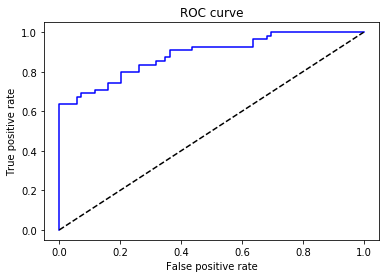

In [12]:
plt.plot(fp,tp,'b-')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [13]:
roc_auc = auc(fp,tp)
print('AUC:', roc_auc)

AUC: 0.8866930171277998


In [14]:
acc = accuracy_score(y_test,y_test_pred)
print('Accuracy:', acc)

Accuracy: 0.7741935483870968


In [15]:
precision = precision_score(y_test,y_test_pred)
print('Precision:',precision)

Precision: 0.7076923076923077


In [16]:
recall = recall_score(y_test,y_test_pred)
print('Recall:',recall)

Recall: 0.8363636363636363


The peformance for each class is shown in detail by the confusion matrix.

Text(0.5, 15.0, 'Predicted label')

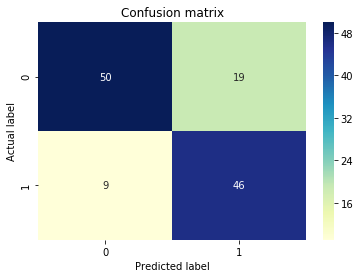

In [17]:
cnf_matrix = confusion_matrix(y_test, y_test_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')